In [1]:
import cv2
import csv
import os

## Openpose로 이미지의 관절 좌표 csv에 저장

In [2]:
def extract_keypoints(frame, proto_file, weights_file, threshold, model_name, BODY_PARTS):
    global points

    net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

    image_height = 1056
    image_width = 720

    input_blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (image_width, image_height), (0, 0, 0), swapRB=False, crop=False)

    net.setInput(input_blob)

    out = net.forward()
    out_height = out.shape[2]
    out_width = out.shape[3]

    frame_height, frame_width = frame.shape[:2]

    points = []

    for i in range(len(BODY_PARTS)):
        prob_map = out[0, i, :, :]
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)

        x = (frame_width * point[0]) / out_width
        x = int(x)
        y = (frame_height * point[1]) / out_height
        y = int(y)

        points.append((x, y))

    return points

In [3]:
def save_keypoints_to_csv(file_name, keypoints):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header = []
        for part_index in range(len(BODY_PARTS_MPI)):
            header.extend([f"{BODY_PARTS_MPI[part_index]}_X", f"{BODY_PARTS_MPI[part_index]}_Y"])
        writer.writerow(header)
        
        for keypoints_frame in keypoints:
            row = []
            for part_index in range(len(BODY_PARTS_MPI)):
                if len(keypoints_frame) > part_index:
                    row.extend([keypoints_frame[part_index][0], keypoints_frame[part_index][1]])
                else:
                    row.extend([None, None])
            writer.writerow(row)


In [4]:
protoFile_mpi = "openpose-master/models/pose/mpi/pose_deploy_linevec.prototxt"
weightsFile_mpi = "openpose-master/models/pose/mpi/pose_iter_160000.caffemodel"

In [5]:
BODY_PARTS_MPI = {
    0: "Head",
    1: "Neck",
    2: "RShoulder",
    3: "RElbow",
    4: "RWrist",
    5: "LShoulder",
    6: "LElbow",
    7: "LWrist",
    8: "RHip",
    9: "RKnee",
    10: "RAnkle",
    11: "LHip",
    12: "LKnee",
    13: "LAnkle",
    14: "Chest",
    15: "Background"
}

In [6]:
threshold = 0.2

In [7]:
all_keypoints = []

In [8]:
image_directory = "shoulder"

start_index = 1
end_index = 1400

In [ ]:
for image_index in range(start_index, end_index+1):
    image_filename = f"frame{image_index:05d}.jpg"  
    image_path = os.path.join(image_directory, image_filename)

    frame = cv2.imread(image_path)

    keypoints = extract_keypoints(frame, protoFile_mpi, weightsFile_mpi, threshold, "MPI", BODY_PARTS_MPI)
    all_keypoints.append(keypoints)

    print(f"Processed image {image_index}/{end_index}")

save_keypoints_to_csv("keypoints.csv", all_keypoints)

## 관절 좌표값을 활용하여 어깨 비대칭 진단 모델 만들기

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [26]:
data = pd.read_csv("keypoints.csv")
selected_columns = ["Head_X", "Head_Y", "Neck_X", "Neck_Y", "RShoulder_X", "RShoulder_Y", "LShoulder_X", "LShoulder_Y"]
data = data[selected_columns]

In [27]:
data["Shoulder_Asymmetry"] = abs(data["RShoulder_X"] - data["LShoulder_X"])


In [28]:
shoulder_vector = data[["RShoulder_X", "RShoulder_Y"]].values - data[["LShoulder_X", "LShoulder_Y"]].values
shoulder_angle = np.arctan2(shoulder_vector[:, 1], shoulder_vector[:, 0]) * 180 / np.pi
data["Shoulder_Angle"] = abs(shoulder_angle)

In [29]:
threshold = 100

In [30]:
data["Label"] = 0  
data.loc[data["Shoulder_Asymmetry"] > threshold, "Label"] = 1 

In [31]:
train, test = train_test_split(data, test_size=0.15, random_state=1)
train, val = train_test_split(train, test_size = 0.18, random_state=1)

train.shape, val.shape, test.shape

((1049, 11), (231, 11), (227, 11))

In [32]:
majority_class = train["Label"].mode()[0]

y_pred = [majority_class] * len(val)

print("최빈 클래스: ", majority_class)
print("validation 데이터셋 정확도: ", accuracy_score(val["Label"], y_pred))

최빈 클래스:  0
validation 데이터셋 정확도:  0.5194805194805194


In [33]:
feature = ["Head_X", "Head_Y", "Neck_X", "Neck_Y", "RShoulder_X", "RShoulder_Y", "LShoulder_X", "LShoulder_Y", "Shoulder_Angle"]
target = "Label"

X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

feature Matrix:  (1049, 9) (231, 9) (227, 9)
target vector:  (1049,) (231,) (227,)


In [34]:
scaler = StandardScaler()

X_train_sclaed = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_sclaed.T[0].mean(), X_train_sclaed.std()

(4.741467254833843e-17, 1.0)

In [35]:
logistic = LogisticRegression()
logistic.fit(X_train_sclaed, y_train)

print("validation 데이터셋 정확도")
logistic.score(X_val_scaled, y_val)

validation 데이터셋 정확도


0.7316017316017316

In [36]:
X_total = pd.concat([X_train, X_test])
y_total = pd.concat([y_train, y_test])

feature = ["Head_X", "Head_Y", "Neck_X", "Neck_Y", "RShoulder_X", "RShoulder_Y", "LShoulder_X", "LShoulder_Y", "Shoulder_Angle"]
target = "Label"

scaler = StandardScaler()

X_total_sclaed = scaler.fit_transform(X_total)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_total_sclaed, y_total)

print("test 데이터셋 정확도")
model.score(X_test_scaled, y_test)

test 데이터셋 정확도


0.7709251101321586

In [37]:
model_coef = pd.Series(model.coef_[0], feature).sort_values(ascending=False)
model_coef

RShoulder_X       1.384290
Shoulder_Angle    1.203212
LShoulder_Y       0.802520
Neck_X            0.279120
Head_Y            0.055324
Head_X           -0.074027
RShoulder_Y      -0.373707
Neck_Y           -0.396653
LShoulder_X      -1.914064
dtype: float64

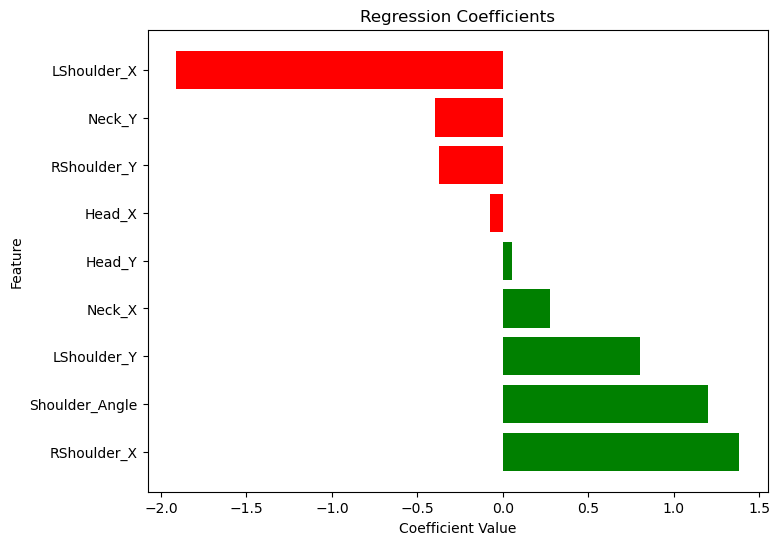

In [38]:
plt.figure(figsize=(8, 6))
colors = ['green' if coef > 0 else 'red' for coef in model_coef.values]
plt.barh(model_coef.index, model_coef.values, color=colors)

plt.title("Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")

plt.show()

In [39]:
y_val_pred = model.predict(X_val_scaled)

f1 = f1_score(y_val, y_val_pred)

print("Validation 데이터셋의 F1 스코어:", f1)


Validation 데이터셋의 F1 스코어: 0.7009345794392524


In [40]:
y_test_pred = model.predict(X_test_scaled)

f1_test = f1_score(y_test, y_test_pred)

print("Test 데이터셋의 F1 스코어:", f1_test)

Test 데이터셋의 F1 스코어: 0.7263157894736842


In [41]:
print("validation 데이터셋의 F1 스코어:", f1)
print("test 데이터셋의 F1 스코어:", f1_test)
print("validation 데이터셋 정확도:", logistic.score(X_val_scaled, y_val))
print("test 데이터셋 정확도:", model.score(X_test_scaled, y_test))


validation 데이터셋의 F1 스코어: 0.7009345794392524
test 데이터셋의 F1 스코어: 0.7263157894736842
validation 데이터셋 정확도: 0.7316017316017316
test 데이터셋 정확도: 0.7709251101321586
